# GNN для предсказания band gap TMDC

Демонстрация обучения модели на данных IDAO-2022.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from source.train import train_model, evaluate_model
from source.graph import build_graph_from_structure
from source.dataset import GraphListDataset
import random

from pathlib import Path
import pandas as pd
import json
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split


random.seed(42)
np.random.seed(42)

## 1. Загрузка конфигурации и подготовка данных

In [2]:
DATA_PATH = "./data/dichalcogenides_public"
EWT_EPSILON = 0.1  # порог в эВ для Energy within Threshold

def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

def prepare_dataset(dataset_path, test_size=0.3, seed=600):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0).iloc[:, 0]
    struct = {
        item.stem: read_pymatgen_dict(item)
        for item in (dataset_path / "structures").iterdir()
        if item.suffix == ".json"
    }

    data = pd.DataFrame({"structures": pd.Series(struct)})
    data = data.join(targets.rename("targets"))
    data = data.dropna(subset=["targets"])

    return train_test_split(data, test_size=test_size, random_state=seed)

train, test = prepare_dataset(DATA_PATH)
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 2076, Test size: 890


## 2. Преобразование структур в графы

Создаем графы для каждого материала и формируем словарь `datasets` с train/val/test.

In [3]:
def dataframe_to_graphs(df, cutoff=4.0, rbf_dim=16):
    graphs = []
    for _, row in df.iterrows():
        structure = row["structures"]
        target = row["targets"]
        target_val = float(np.asarray(target).reshape(-1)[0])
        graph = build_graph_from_structure(structure, cutoff=cutoff, rbf_dim=rbf_dim)
        graph.y = np.asarray([target_val], dtype=np.float32)
        graphs.append(graph)
    return GraphListDataset(graphs)

rng = np.random.default_rng(42)
indices = np.arange(len(train))
rng.shuffle(indices)
val_size = int(len(train) * 0.1)
val_idx = indices[:val_size]
train_idx = indices[val_size:]

train_df = train.iloc[train_idx]
val_df = train.iloc[val_idx]

datasets = {
    "train": dataframe_to_graphs(train_df),
    "val": dataframe_to_graphs(val_df),
    "test": dataframe_to_graphs(test),
}


## 3. Обучение модели

Обучаем NumPy-реализацию GNN и сохраняем историю ошибок.

In [4]:
sample = datasets["train"][0]
node_feat_dim = sample.x.shape[-1]
edge_feat_dim = sample.edge_attr.shape[-1]

model, history = train_model(
    train_dataset=datasets["train"],
    val_dataset=datasets["val"],
    node_feat_dim=node_feat_dim,
    edge_feat_dim=edge_feat_dim,
    epochs=8,
    lr=5e-4,
    batch_size=32,
    hidden_dim=64,
    num_layers=3,
    grad_clip=0.5,
    normalize_y=True,
    ewt_epsilon=EWT_EPSILON,
)

Epoch 1/8 | train_mse=0.8111 val_mse=0.1913 train_mae=0.3988 val_mae=0.3826 train_ewt=0.009 val_ewt=0.014
Epoch 2/8 | train_mse=0.7521 val_mse=0.1759 train_mae=0.3795 val_mae=0.3616 train_ewt=0.018 val_ewt=0.014
Epoch 3/8 | train_mse=0.6983 val_mse=0.1616 train_mae=0.3608 val_mae=0.3397 train_ewt=0.022 val_ewt=0.029
Epoch 4/8 | train_mse=0.6393 val_mse=0.1484 train_mae=0.3393 val_mae=0.3211 train_ewt=0.029 val_ewt=0.029
Epoch 5/8 | train_mse=0.5823 val_mse=0.1333 train_mae=0.3167 val_mae=0.2962 train_ewt=0.036 val_ewt=0.068
Epoch 6/8 | train_mse=0.5254 val_mse=0.1218 train_mae=0.2938 val_mae=0.2754 train_ewt=0.059 val_ewt=0.106
Epoch 7/8 | train_mse=0.4831 val_mse=0.1127 train_mae=0.2751 val_mae=0.2570 train_ewt=0.143 val_ewt=0.140
Epoch 8/8 | train_mse=0.4472 val_mse=0.1023 train_mae=0.2577 val_mae=0.2355 train_ewt=0.219 val_ewt=0.391


## 4. Оценка и визуализация

Считаем метрики на test (или val) и строим графики.

Eval loss: 0.1136, MAE: 0.2581, EwT: 0.330


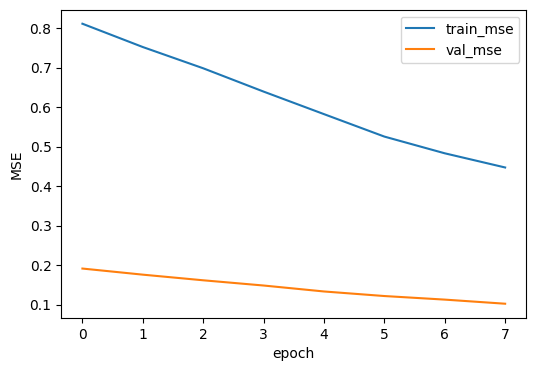

In [5]:
eval_dataset = datasets["test"]
if not hasattr(datasets["test"][0], "y"):
    print("Test split has no targets; evaluating on val split.")
    eval_dataset = datasets["val"]

test_loss, test_mae, test_ewt = evaluate_model(model, eval_dataset, ewt_epsilon=EWT_EPSILON)
print(f"Eval loss: {test_loss:.4f}, MAE: {test_mae:.4f}, EwT: {test_ewt:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(history["train_loss"], label="train_mse")
plt.plot(history["val_loss"], label="val_mse")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()